In [1]:
# resnet50
!pip install -q timm torch torchvision scikit-learn seaborn
import os, shutil, torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# 👇 change this path to your folder in Drive
base_dir = '/content/drive/MyDrive/oral_cancer_dataset'   # contains Benign, Healthy, OCA, OPMD

# Merge into two classes
merged_dir = '/content/oral_cancer_2class'
os.makedirs(os.path.join(merged_dir, 'Healthy'), exist_ok=True)
os.makedirs(os.path.join(merged_dir, 'Oral_Cancer'), exist_ok=True)

# Copy images into the new structure
for src_cls, dest_cls in [
    ('OCA', 'Oral_Cancer'),
    ('OPMD', 'Oral_Cancer'),
    ('Benign', 'Healthy'),
    ('Healthy', 'Healthy')
]:
    src = os.path.join(base_dir, src_cls)
    if os.path.exists(src):
        for f in os.listdir(src):
            src_path = os.path.join(src, f)
            dst_path = os.path.join(merged_dir, dest_cls, f'{src_cls}_{f}')
            if os.path.isfile(src_path):
                shutil.copy(src_path, dst_path)

for cls in os.listdir(merged_dir):
    print(cls, "→", len(os.listdir(os.path.join(merged_dir, cls))), "images")


Mounted at /content/drive
Oral_Cancer → 1523 images
Healthy → 1478 images


In [7]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Function to check if an image is loadable
def is_image_loadable(path):
    try:
        img = Image.open(path)
        img.verify()  # Verify that the file is a valid image
        return True
    except Exception:
        return False

from PIL import Image

# Create a custom dataset that filters out corrupted images
class FilteredImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, loader=datasets.folder.default_loader, is_valid_file=None):
        super().__init__(root, transform=transform, target_transform=target_transform, loader=loader, is_valid_file=is_image_loadable)

dataset = FilteredImageFolder(merged_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)

print("Classes:", dataset.classes)
print("Number of valid images in dataset:", len(dataset))

Classes: ['Healthy', 'Oral_Cancer']
Number of valid images in dataset: 3001


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

model = models.resnet50(weights='IMAGENET1K_V1')   # pretrained ImageNet
for param in model.parameters():
    param.requires_grad = True                      # fine-tune all layers

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)               # 2 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


In [5]:
epochs = 5
for epoch in range(epochs):
    model.train()
    total, correct, running_loss = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}%")


Epoch 1/5 | Loss: 0.6291 | Train Acc: 64.04%
Epoch 2/5 | Loss: 0.5322 | Train Acc: 72.75%
Epoch 3/5 | Loss: 0.4354 | Train Acc: 80.17%
Epoch 4/5 | Loss: 0.3757 | Train Acc: 83.75%
Epoch 5/5 | Loss: 0.2912 | Train Acc: 87.33%


In [8]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print("\n✅ ResNet-50 Performance:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print("\nDetailed Classification Report:\n", classification_report(y_true, y_pred, target_names=dataset.classes))



✅ ResNet-50 Performance:
Accuracy : 0.9018
Precision: 0.8944
Recall   : 0.8975
F1-Score : 0.8959

Detailed Classification Report:
               precision    recall  f1-score   support

     Healthy       0.91      0.91      0.91       318
 Oral_Cancer       0.89      0.90      0.90       283

    accuracy                           0.90       601
   macro avg       0.90      0.90      0.90       601
weighted avg       0.90      0.90      0.90       601



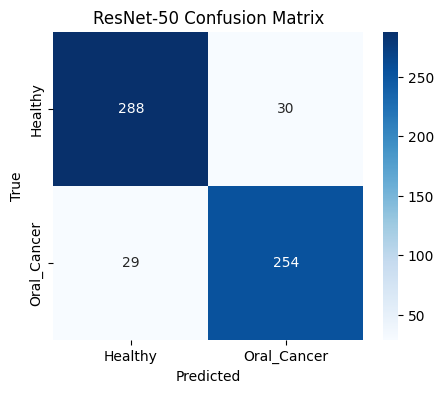

In [9]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ResNet-50 Confusion Matrix')
plt.show()


In [10]:
torch.save(model.state_dict(), '/content/resnet50_oral_cancer_model.pth')
print("✅ Model saved successfully !")


✅ Model saved successfully !
